# Exoplanet Explorer with AI Assistant
This project creates a query system that combines:
- **Pandas** for data analysis and cleaning up
- **LLM function calling** to allow for active conversations
- **Real NASA data** with 5000+ confirmed exoplanets


## Project Overview

In [ ]:
"""
This project uses AI and Pandas to explore NASA's exoplanet database.
Users ask natural language questions and the AI calls Python functions 
to analyze real exoplanet data.

Example queries:
- "Find all hot Jupiters"
- "Which planets could have liquid water?"
- "Show me planets similar to Earth"
"""

## Setup and Imports

First, I import the required libraries and install any missing packages.
This also adds the option to use an anthropic api key.


In [1]:
!pip install pandas numpy matplotlib anthropic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import anthropic
import os
import getpass

# Get API Key
api_key = getpass.getpass("Enter your Anthropic API key (or press Enter for demo mode): ").strip()

if api_key:
    os.environ["ANTHROPIC_API_KEY"] = api_key
    print("\n API key saved. Running in AI Assistant mode.\n")
else:
    os.environ.pop("ANTHROPIC_API_KEY", None)
    print("\n No API key entered. Running in DEMO mode.\n")

Enter your Anthropic API key (or press Enter for demo mode):  ········



 No API key entered. Running in DEMO mode.



## Data Acquisition and Cleaning

We load exoplanet data directly from NASA's Exoplanet Archive using their TAP (Table Access Protocol) service. This provides access to the latest confirmed exoplanet discoveries with detailed physical properties.

Source: [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)

The dataset includes properties such as:
- Planet mass (Earth and Jupiter)
- Planet radius (Earth and Jupiter)
- Orbital period (days)
- Equilibrium temperature (Kelvin)
- Discovery method

I then perform several data cleaning steps using Pandas:
1. **Standardize column names** - Convert to lowercase and strip whitespace
2. **Select key columns** - Focus on essential properties for our analysis
3. **Handle missing values** - Remove entries without planet names
4. **Validate data types** - Ensure numeric columns are properly formatted
5. **Removing Duplicates** - On

This cleans up the data and removes unnecessary parts

In [2]:
print("Loading exoplanet data from NASA...")
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv"

df = pd.read_csv(url)
df = df.drop_duplicates(subset=['pl_name'])
print(f"Loaded {len(df)} exoplanets")

# Clean up column names
df.columns = df.columns.str.strip().str.lower()

# Keep only the columns we need
columns_to_keep = ['pl_name', 'pl_masse', 'pl_massj', 'pl_rade', 'pl_radj', 'pl_orbper', 'pl_eqt']
df = df[columns_to_keep]

# Remove planets without names
df = df.dropna(subset=['pl_name'])

print(f"Cleaned data: {len(df)} planets")
print(f"Planets with mass: {df['pl_masse'].notna().sum()}")
print(f"Planets with radius: {df['pl_rade'].notna().sum()}")
print(f"Planets with temperature: {df['pl_eqt'].notna().sum()}")


Loading exoplanet data from NASA...


C:\Users\evans\AppData\Local\Temp\ipykernel_4272\775172894.py:4: DtypeWarning: Columns (3,4,36,51,56,66,96,100,104,108,128,149,154,163,184,188,207,212,238,243,258) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


Loaded 6042 exoplanets
Cleaned data: 6042 planets
Planets with mass: 1154
Planets with radius: 3581
Planets with temperature: 2529


## Function Tools for Data Analysis

I create five specialized functions that the AI can call to query the exoplanet database:

1. **filter_by_mass()** - Filter planets by mass range (Earth or Jupiter masses)
2. **filter_by_radius()** - Filter planets by radius range
3. **find_hot_jupiters()** - Identify gas giants close to their host stars
4. **find_earth_like()** - Find planets similar to Earth in size and mass
5. **filter_by_temperature()** - Find planets in specific temperature ranges

Each function uses Pandas operations to filter the DataFrame and return results.

### Astronomy Vocab:
**Hot Jupiters:** Gas giants (> 0.3 Jupiter masses) with very short orbital periods (< 10 days.
**Earth-like planets:** Planets with a mass and radius that is within 50% of Earth's mass and radius.
**Habitable zone:** Temperature range of 200-350K where liquid water could exist.

In [3]:

def filter_by_mass(min_mass=None, max_mass=None, unit='earth'):
    """Filter planets by mass."""
    col = 'pl_masse' if unit == 'earth' else 'pl_massj'
    filtered = df[df[col].notna()]
    
    if min_mass:
        filtered = filtered[filtered[col] >= min_mass]
    if max_mass:
        filtered = filtered[filtered[col] <= max_mass]
    
    return {
        'count': len(filtered),
        'planets': filtered['pl_name'].tolist()[:15],
        'average_mass': float(filtered[col].mean())
    }

def filter_by_radius(min_radius=None, max_radius=None, unit='earth'):
    """Filter planets by radius."""
    col = 'pl_rade' if unit == 'earth' else 'pl_radj'
    filtered = df[df[col].notna()]
    
    if min_radius:
        filtered = filtered[filtered[col] >= min_radius]
    if max_radius:
        filtered = filtered[filtered[col] <= max_radius]
    
    return {
        'count': len(filtered),
        'planets': filtered['pl_name'].tolist()[:15],
        'average_radius': float(filtered[col].mean())
    }

def find_hot_jupiters():
    """Find hot Jupiters - big planets close to their stars."""
    filtered = df[(df['pl_massj'] > 0.3) & (df['pl_orbper'] < 10)]
    filtered = filtered.dropna(subset=['pl_massj', 'pl_orbper'])
    
    return {
        'count': len(filtered),
        'planets': filtered['pl_name'].tolist()[:15],
        'info': 'Hot Jupiters are gas giants very close to their stars'
    }

def find_earth_like():
    """Find planets similar to Earth in size and mass."""
    filtered = df[
        (df['pl_masse'] > 0.5) & (df['pl_masse'] < 1.5) &
        (df['pl_rade'] > 0.5) & (df['pl_rade'] < 1.5)
    ]
    filtered = filtered.dropna(subset=['pl_masse', 'pl_rade'])
    
    results = []
    for i, row in filtered.head(10).iterrows():
        results.append({
            'name': row['pl_name'],
            'mass': row['pl_masse'],
            'radius': row['pl_rade']
        })
    
    return {
        'count': len(filtered),
        'planets': results
    }

def filter_by_temperature(min_temp=None, max_temp=None):
    """Filter planets by temperature. Habitable zone is ~200-350K."""
    filtered = df[df['pl_eqt'].notna()]
    
    if min_temp:
        filtered = filtered[filtered['pl_eqt'] >= min_temp]
    if max_temp:
        filtered = filtered[filtered['pl_eqt'] <= max_temp]
    
    return {
        'count': len(filtered),
        'planets': filtered['pl_name'].tolist()[:15],
        'average_temp': float(filtered['pl_eqt'].mean())
    }


## LLM Integration

I define functions that tell Anthropic what each function does and what parameters it accepts. This lets the AI choose the correct tool.
I then use Anthropic AI to interpret natural language questions and call the appropriate functions. 

**How it works:**
1. User asks a question
2. Claude analyzes the question and determines which functions to call
3. The system executes the Python functions with appropriate parameters
4. Claude receives the data results
5. Claude creates a human-readable answer


In [4]:

tools = [
    {
        "name": "find_hot_jupiters",
        "description": "Find hot Jupiters - gas giants close to their stars",
        "input_schema": {"type": "object", "properties": {}}
    },
    {
        "name": "filter_by_mass",
        "description": "Filter planets by mass in Earth or Jupiter masses",
        "input_schema": {
            "type": "object",
            "properties": {
                "min_mass": {"type": "number"},
                "max_mass": {"type": "number"},
                "unit": {"type": "string", "enum": ["earth", "jupiter"]}
            }
        }
    },
    {
        "name": "filter_by_radius",
        "description": "Filter planets by radius",
        "input_schema": {
            "type": "object",
            "properties": {
                "min_radius": {"type": "number"},
                "max_radius": {"type": "number"},
                "unit": {"type": "string", "enum": ["earth", "jupiter"]}
            }
        }
    },
    {
        "name": "find_earth_like",
        "description": "Find Earth-like planets",
        "input_schema": {"type": "object", "properties": {}}
    },
    {
        "name": "filter_by_temperature",
        "description": "Filter by temperature. Habitable zone is 200-350K",
        "input_schema": {
            "type": "object",
            "properties": {
                "min_temp": {"type": "number"},
                "max_temp": {"type": "number"}
            }
        }
    }
]
def ask_question(question, api_key):
    """Ask the AI a question about exoplanets."""
    client = anthropic.Anthropic(api_key=api_key)
    
    # Send question to AI
    messages = [{"role": "user", "content": question}]
    response = client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=1500,
        tools=tools,
        messages=messages
    )
    
    # Check if AI wants to use a tool
    if response.stop_reason == "tool_use":
        results = []
        
        # Call the functions the AI requested
        for block in response.content:
            if block.type == "tool_use":
                func_name = block.name
                func_input = block.input
                
                print(f"Calling function: {func_name}")
                
                # Run the function
                if func_name == "filter_by_mass":
                    result = filter_by_mass(**func_input)
                elif func_name == "filter_by_radius":
                    result = filter_by_radius(**func_input)
                elif func_name == "find_hot_jupiters":
                    result = find_hot_jupiters()
                elif func_name == "find_earth_like":
                    result = find_earth_like()
                elif func_name == "filter_by_temperature":
                    result = filter_by_temperature(**func_input)
                
                results.append({
                    "type": "tool_result",
                    "tool_use_id": block.id,
                    "content": json.dumps(result)
                })
        
        # Send results back to AI for final answer
        messages.append({"role": "assistant", "content": response.content})
        messages.append({"role": "user", "content": results})
        
        final = client.messages.create(
            model="claude-sonnet-4-5-20250929",
            max_tokens=1500,
            tools=tools,
            messages=messages
        )
        
        # Get the text response
        answer = ""
        for block in final.content:
            if hasattr(block, 'text'):
                answer += block.text
        return answer
    
    # If no tools needed, just return the response
    answer = ""
    for block in response.content:
        if hasattr(block, 'text'):
            answer += block.text
    return answer


## Data Visualization

I create two key visualizations to understand the exoplanet population:

1. **Mass Distribution** - Shows how planet masses are distributed (most are small)
2. **Temperature Distribution** - Displays temperature ranges and includes the habitable zone highlighted in green


In [5]:
def make_plots():
    """Create simple plots of the data."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Mass distribution
    mass_data = df[df['pl_masse'].notna()]['pl_masse']
    mass_data = mass_data[mass_data < 30]  # Only show planets under 30 Earth masses
    axes[0].hist(mass_data, bins=30, color='blue', edgecolor='black')
    axes[0].set_xlabel('Mass (Earth masses)')
    axes[0].set_ylabel('Number of Planets')
    axes[0].set_title('Planet Mass Distribution')
    
    # Plot 2: Temperature distribution
    temp_data = df[df['pl_eqt'].notna()]['pl_eqt']
    axes[1].hist(temp_data, bins=30, color='red', edgecolor='black')
    axes[1].set_xlabel('Temperature (Kelvin)')
    axes[1].set_ylabel('Number of Planets')
    axes[1].set_title('Planet Temperature Distribution')
    axes[1].axvspan(200, 350, alpha=0.3, color='green', label='Habitable Zone')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('exoplanet_plots.png', dpi=150)
    plt.show()


## Interactive Query System

Now we run the interactive system. The program operates in two modes:

**With API Key (Full Mode):**
- Type any natural language question about exoplanets
- Type 'examples' to see demo queries
- Type 'plots' to generate visualizations
- Type 'quit' to exit

**Without API Key (Demo Mode):**
- Choose from a menu of pre-built queries
- Still demonstrates all data analysis functions
- Can create visualizations




EXOPLANET EXPLORER

No API key found. Running in demo mode...

Choose an option:
1. Find hot Jupiters
2. Find Earth-like planets
3. Find planets in habitable zone
4. Create visualizations
5. Exit



Enter your choice (1-5):  4



Creating visualizations...


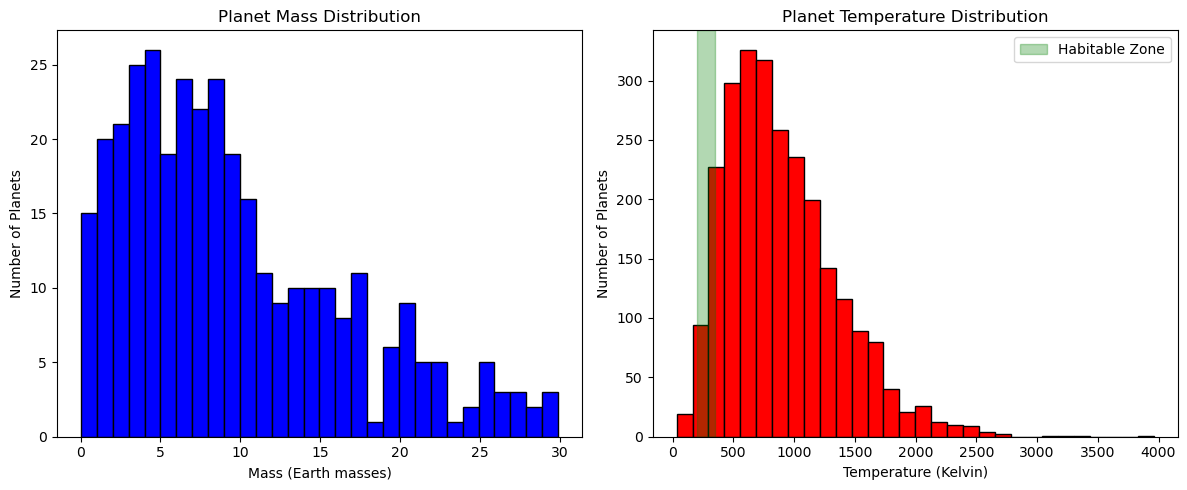

Plots saved as 'exoplanet_plots.png'



Enter your choice (1-5):  5


Thanks for exploring exoplanets!

DONE!


In [6]:
print("\n" + "="*60)
print("EXOPLANET EXPLORER")
print("="*60)

# Get API key
api_key = os.environ.get("ANTHROPIC_API_KEY", None)

if api_key:
    print("\nAI Assistant ready! You can ask questions about exoplanets.")
    print("\nExample questions you can ask:")
    print("  - 'Find all hot Jupiters'")
    print("  - 'Which planets might have liquid water?'")
    print("  - 'Show me planets similar to Earth'")
    print("  - 'Find planets larger than Jupiter'")
    print("  - 'What planets are in the habitable zone?'")
    
    print("\n" + "="*60)
    print("INTERACTIVE MODE")
    print("="*60)
    
    # Interactive loop
    while True:
        question = input("\nYour question (or type 'quit' to exit): ").strip()
        
        if question.lower() in ['quit', 'exit', 'q']:
            print("Thanks for exploring exoplanets!")
            break
        
        if question.lower() == 'examples':
            # Run example questions
            examples = [
                "Find all hot Jupiters in the database",
                "Which planets might have liquid water?",
                "Show me planets similar to Earth"
            ]
            for q in examples:
                print(f"\nQ: {q}")
                answer = ask_question(q, api_key)
                print(f"A: {answer}")
            continue
        
        if question.lower() == 'plots':
            print("\nCreating visualizations...")
            make_plots()
            continue
        
        if not question:
            print("Please enter a question!")
            continue
        
        # Ask the AI
        print(f"\nProcessing your question...")
        answer = ask_question(question, api_key)
        print(f"\nAnswer: {answer}")

else:
    print("\nNo API key found. Running in demo mode...")
    print("\nChoose an option:")
    print("1. Find hot Jupiters")
    print("2. Find Earth-like planets")
    print("3. Find planets in habitable zone")
    print("4. Create visualizations")
    print("5. Exit")
    
    while True:
        choice = input("\nEnter your choice (1-5): ").strip()
        
        if choice == '1':
            print("\nSearching for hot Jupiters...")
            result = find_hot_jupiters()
            print(f"Found {result['count']} hot Jupiters")
            print(f"Examples: {result['planets'][:5]}")
            
        elif choice == '2':
            print("\nSearching for Earth-like planets...")
            result = find_earth_like()
            print(f"Found {result['count']} Earth-like planets")
            if result['planets']:
                print("Examples:")
                for p in result['planets'][:5]:
                    print(f"  - {p['name']}: Mass={p['mass']:.2f} Earth masses, Radius={p['radius']:.2f} Earth radii")
            
        elif choice == '3':
            print("\nSearching for planets in habitable zone (200-350K)...")
            result = filter_by_temperature(200, 350)
            print(f"Found {result['count']} planets in potential habitable zone")
            print(f"Average temperature: {result['average_temp']:.1f} K")
            print(f"Examples: {result['planets'][:5]}")
            
        elif choice == '4':
            print("\nCreating visualizations...")
            make_plots()
            print("Plots saved as 'exoplanet_plots.png'")
            
        elif choice == '5':
            print("Thanks for exploring exoplanets!")
            break
        
        else:
            print("Invalid choice. Please enter 1-5.")

print("\n" + "="*60)
print("DONE!")
print("="*60)


## Github:
https://github.com/Evan-Stiverson/Astro_Data_Project_2/upload/main